In [1]:
import os
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 256
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
d = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

g = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

In [3]:
class GAN(pl.LightningModule):
    def __init__(self, d, g):
        super().__init__()
        self.d = d
        self.g = g
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        z = torch.randn(imgs.shape[0], 100)
        z = z.type_as(imgs)
        
        # generator
        if optimizer_idx == 0:
            imgs = imgs.view(imgs.size(0), -1)
            
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
            
            g_loss = F.binary_cross_entropy(self.d(self.g(z)), valid)
            output = OrderedDict({"loss": g_loss})
            
            return output
        
        elif optimizer_idx == 1:
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
            
            real_loss = F.binary_cross_entropy(self.d(imgs), valid)
            
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)
            
            fake_loss = F.binary_cross_entropy(self.d(self.g(z).detach()), fake)

            d_loss = (real_loss + fake_loss) / 2
            output = OrderedDict({"loss": d_loss})
            
            return output
    
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        z = torch.randn(imgs.shape[0], 100)
        z = z.type_as(imgs)
        
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)
        
        g_loss = F.binary_cross_entropy(self.d(self.g(z)), valid)
        output = OrderedDict({"loss": g_loss})
    
        
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.g.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.d.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        return [opt_g, opt_d], []

model = GAN(d, g)
trainer = pl.Trainer(gpus=1, max_epochs=10)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
trainer.fit(model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type       | Params
------------------------------------
0 | d    | Sequential | 201 K 
1 | g    | Sequential | 227 K 
------------------------------------
428 K     Trainable params
0         Non-trainable params
428 K     Total params
1.714     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

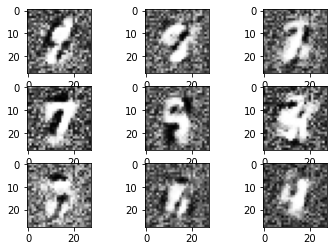

In [5]:
import matplotlib.pyplot as plt

samples = model.g(torch.randn(9, 100)).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()